# Problem Set 1


# Part 1- Hodgkin Huxley Simulation & Action Potential Concepts
In this part of the assignment, we're going to run some simulations of a "neuron" behaving  according to the Hodgkin-Huxley equations. Having completed this part, you should be able to answer the following questions:

1. What is Euler's method and how do I code it?
2. How do the various terms in the Hodgkin-Huxley model contribute to the system's behaviour?

A note on grading: You will be graded on correctness and also clarity. That means code should be readable and commented. For all plots, make sure to label your axes. **If these code practices aren't followed, half the points for the question will be removed.**


## Differential equations background

At the most basic level, a differential equation relates the value of a function to its derivatives. In sciences that deal with complex dynamical systems (e.g. neuroscience), they are a convenient tool to describe the behaviour of a system in terms of how its constituent parts change over time -- it is often easier to specify a series of time-derivatives than to write down an equation that immediately gives the state of the system at any given time. 

For concreteness, let's say you have some function $f(t)$. A differential equation looks something like $\frac{df(t)}{dt} = g(f(t))$, where the derivative of a function is related to the function itself through another function $g$. One fundamental example is $\frac{df(t)}{dt} = f(t)$ (the derivative of $f$ is equal to $f$). When we have a differential equation such as this, we often would like to find its **solution**; the solution to a differential equation is the value of $f(t)$ for a set of times that we might be interested in. 

This can be provided in two ways. For some differential equations there exists an analytical solution -- i.e. it is possible to derive a closed-form expression for $f(t)$ that doesn't depend on any derivatives. The differential equation example from the previous paragraph, for instance, admits an analytical solution $f(t) = e^t$. These are ideal, because we can just plug in whatever value of $t$ we care about without doing any additional work. Some differential equations, however, don't have an analytical solution. 

For these, we have to engage in a process called "numerical integration". Essentially, this means that we will approximate the value of $f(t)$ by some numerical process. The most simple example of this is Euler's method. In general, it comes down to the following equation:

$$
    f(t + \Delta t) \approx f(t) + \Delta t \frac{df(t)}{dt}
$$

In English: if you know $f(t)$ for a particular $t$, and you know the time-derivative of that function also at that $t$, then you can approximate the value of the function a short time later $f(t + \Delta t)$ as $f(t) + \Delta t \frac{df(t)}{dt}$. This means that if you have an initial value for your function (e.g. you know that $f(0) = 1$), and if you have a way of computing derivatives for your function (e.g. you have an expression for $\frac{df(t)}{dt}$) then you can approximate the value of that function at any other time. 

In practice, these simulations work best if $\Delta t$ is very small (and in fact work better the smaller $\Delta t$ is). So if you want to know the value of your function $f$ at a time $t'$ that is very far away from the time you know $f(0)$, you might choose a very small $\Delta t << t'$ and iteratively compute $f(\Delta t), f(2 \Delta t), ..., f(t' - \Delta t), f(t')$ to maintain accuracy. 

This $\Delta t$ is often known as a time-step.

## Simulating a Hodgkin-Huxley neuron

The Hodgkin-Huxley model consists of four differential equations that together define a dynamical system. This dynamical system computes the voltage of a space-clamped membrane as a function of time $t$ and three other variables $n, m,$ and $h$. These equations are:

$$ 
    \frac{dV}{dt} = \frac{I - \bar{g}_{Na}m^3h(V - V_{Na}) - \bar{g}_Kn^4(V - V_K) - g_L(V - V_L)}{C} \\
    \frac{dn}{dt} = \alpha_n(V)(1 - n) - \beta_n(V)n \\
    \frac{dm}{dt} = \alpha_m(V)(1 - m) - \beta_m(V)m \\
    \frac{dh}{dt} = \alpha_h(V)(1 - h) - \beta_h(V)h
$$

where

$$
    \alpha_n(V) = \frac{0.01(V + 55)}{1 - exp[-\frac{1}{10}(V + 55)]} \quad \quad \quad \beta_n(V) = 0.125 \cdot exp[-\frac{1}{80}(V + 65)] \\
    \alpha_m(V) = \frac{0.1(V + 40)}{1 - exp[-\frac{1}{10}(V + 40)]} \quad \quad \quad \beta_m(V) = 4 \cdot exp[-\frac{1}{18}(V + 65)] \\
    \alpha_h(V) = 0.07 \cdot exp[-\frac{1}{20}(V + 65)] \quad \quad \quad \beta_h(V) = \frac{1}{1 + exp[-\frac{1}{10}(V + 35)]}
$$

As described in lecture, $V$ is the transmembrane potential, $I$ is the current injected into the neuron from a microelectrode, and $n, m,$ and $h$ are dimensionless gating variables. In these equations, voltages are measured in $mV$, current density in $\mu A/cm^2$, capacitance density in $\mu F/cm^2$, and time in $ms$. The values of the constants at $6.3^{\circ}C$ are:

$$
    \bar{g}_{Na} = 120 mmho/cm^2 \quad \quad \bar{g}_K = 36 mmho/cm^2 \quad \quad g_L = 0.3 mmho/cm^2 \\
    V_{Na} = 50 mV \quad \quad V_K = -77mV \quad \quad V_L = -54.4mV \quad \quad C = 1 \mu F/cm^2 
$$

N.B. These equations are written using modern conventions and look a little different than they do in the original Hodgkin-Huxley (1952) paper. One obtains the equations in this paper by letting $V_{HH} = -V - 65$.

## Question 1: Code the Simulator [15] 
Throughout this problem set, you will be running multiple simulations of the Hodgkin-Huxley equations with a variety of settings for the different parameters. **Following the steps below**, write a function that accepts, as inputs, parameters for a Hodgkin-Huxley simulation and returns a list or array of voltage values computed over the course of the simulation.

This function should itself call several other functions that implement each of the HH equations individually.

In [1]:
# libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

colors = plt.cm.tab10(np.linspace(0, 1, 10))


### Question 1.1 [2]

Write functions to calculate the alpha and beta variables for each gating variable (you can write one overall comment for input/output documentation, but you must give your functions meaninful labels).

In [2]:
"""
Voltage-dependent transition rates 𝛼 and 𝛽 per gating variable (n,m,h):

Input: 
    V (float) the transmembrane potential
Output: 
    (float) the transition rate parameter (alpha or beta) per gating variable (n, m, h)
"""

alpha_n = lambda V: 0.01*(V+55) / (1-np.exp(-(V+55)/10))
beta_n = lambda V: 0.125*np.exp(-(V+65)/80)

alpha_m = lambda V: 0.1*(V+40) / (1-np.exp(-(V+40)/10))
beta_m = lambda V: 4*np.exp(-(V+65)/18)

alpha_h = lambda V: 0.07*np.exp(-(V+65)/20)
beta_h = lambda V: 1 / (1+np.exp(-(V+35)/10))

### Question 1.2 [2]

Write a function to solve the differential equation for each gating variable. Please document inputs/outputs of each function and give meaninful names. (Hint: you should be calling the functions from 1.1)

In [3]:
"""
Differential equations describing the activation (and inactivation) dynamics of each channel 
    defined in terms of their voltage-dependent transition rates 𝛼 and 𝛽.

Input: 
    V (float) the transmembrane potential at time t
    n/m/h (float) the relevant dimensionless parameter at time t
Output: 
    (float) change of gating variable value as a function of time $t$
"""

dn_dt = lambda V,n: alpha_n(V)*(1-n) - beta_n(V)*n
dm_dt = lambda V,m: alpha_m(V)*(1-m) - beta_m(V)*m
dh_dt = lambda V,h: alpha_h(V)*(1-h) - beta_h(V)*h

### Question 1.3 [2]

If current = conductance x driving force, then in dV/dt equation above, the numerator can be broken four parts: overall current, sodium current, potassium current and leak current. To keep code clean, write a function to solve for the respective current for each channel type. Please document inputs/outputs of each function and give meaninful names. For quantities given (e.g. g_Na = 120), assign them as optional inputs.

In [4]:
# Values for constants: 

# maximum conductance per chanel (mmho/cm^2)
g_Na = 120
g_K = 36
g_L = .3

# voltage of the battery per chanel (mV)
v_Na = 50
v_K = -77
v_L = -54.4

# capacitor (\mu F/cm^2 )
C=1

# set them in a list (for later use)
constants = [C, g_Na, g_K, g_L, v_Na, v_K, v_L]

"""
Implenets the HH main equation different parts, computing the voltage of each channel 
    at membrane as a function of time $t$
all Inputs: 
    
        V (float) the transmembrane potential
        I (float) over input current
        n/m/h (float) the relevant dimensionless parameter per channel
    
        C (float) capacitor
        g_Na (float) sodium conductance
        g_K (float) potassium conductance
        g_L (float) leak conductance
        v_Na (float) sodium battery voltage
        v_K (float) potassium battery voltage
        v_L (float) leak battery voltage
        
        
Output: 
    (float) channel current
"""

overall_cuurent = lambda I, C: I/C 
sodium_current = lambda  V, m, h, g_Na, v_Na, C: g_Na*(m**3)*h*(V-v_Na) /C
potassium_current = lambda V, n, g_K, v_K, C: g_K*(n**4)*(V-v_K) /C
leak_current = lambda V, g_L, v_L, C: g_L*(V-v_L) /C
    

### Question 1.4 [2]

Great, now you have all the functions you need to cleanly write the differential equation for voltage (dV/dt). Write this function below & document inputs/outputs etc. 

In [5]:
def HH_dV_dt(I, V, n, m, h, C, g_Na, g_K, g_L, v_Na, v_K, v_L):
    """
    Implenets the HH main equation computing the voltage of a 
     space-clamped membrane as a function of time $t$
     
    Input:
        I (float) input current
        V (float) the transmembrane potential
        n/m/h (float) the relevant dimensionless gating parameter per channel
        C (float) capacitor
        g_Na (float) sodium conductance
        g_K (float) potassium conductance
        g_L (float) leak conductance
        v_Na (float) sodium battery voltage
        v_K (float) potassium battery voltage
        v_L (float) leak battery voltage
    
    Output:
        the voltage of a space-clamped membrane as a function of time $t$
    
    """
    return overall_cuurent(I, C) - sodium_current(V, m, h, g_Na, v_Na, C)- \
           potassium_current(V, n, g_K, v_K, C)- leak_current(V, g_L, v_L, C)

    

### Question 1.5 [2]
Our goal is to solve for voltage over time, and this is dependent on many things, as you just coded above. It would be *really* conveinent if we had one function that could take the inputs needed for all the differential equations above, and calculated respective the output. So, next, write a function that does this and **call it d_alldt**. Remember from precept, these values represent how V, n, m, and h change at a single time step. Same coding practices from above apply here.

In [6]:
def d_alldt(I, V, n, m, h, constants=constants):
    '''
    Grouping all relevant HH differential equations
    
    Input:
        I (float) input current at time t
        V (float) the transmembrane potential at time t
        n/m/h (float) the relevant dimensionless gating parameter per channel at time t
        contstant_values (list [C, g_Na, g_K, g_L, v_Na, v_K, v_L]) 
                    default floats representing the constants
    
    Output:
        
        dVdt (float) the change of potential as a function of time $t$
        dmdt (float) the change of gating variable m as a function of time $t$
        dhdt (float) the change of gating variable h as a function of time $t$
        dndt (float) the change of gating variable n as a function of time $t$
   
    
    '''
    dVdt = HH_dV_dt(I, V, n, m, h, *constants)
    dndt = dn_dt(V, n)
    dmdt = dm_dt(V, m)
    dhdt = dh_dt(V, h)
    
    return dVdt, dmdt, dhdt, dndt
    


### Question 1.6 [5]
Okay, now we can actually do some fun stuff! Here is where we get to Euler's method (ie using all your functions over time). Your initial conditions are $V = -65 mV, n = 0.32, m = 0.05, h = 0.6$. 

Remember, each of these differential equations solves for the *change* over time, so you will need to solve them and then add that to the value at the previous time step to get the *new* value. You function should output arrays n, m, h and V over simulated time. **Documentation is a must here, please be explicit**!


In [7]:
def euler_approx_HH(init_values, I, time_step, time_span, constants=constants):
    '''
     Input:
        init_values (list of [V,m,n,h]) values for initial potential (V), gating parameters (n, m, h)
        I (1d array) input currents along time
        time_step (float) the time step size
        time_span (float) max time value (stopping condition)
    
    Output:
        
        V (1d array) potential value at each time step
        m, n, h (1d array) gating parameters value at each time step
    '''
    # number of timesteps
    n_timesteps = int(time_span/time_step)
    
    # preallocate space to save simulated values
    V = np.zeros(n_timesteps)
    m = np.zeros(n_timesteps)
    n = np.zeros(n_timesteps)
    h = np.zeros(n_timesteps)

    # assign initial values
    V[0] = init_values[0]
    m[0] = init_values[1]
    n[0] = init_values[2]
    h[0] = init_values[3]

      
    ## iteratively approximate the numerical value of each of HH's ODEs
    for time_i in range(1, n_timesteps):
        
        # current value
        dVdt, dmdt, dhdt, dndt = d_alldt(I[time_i-1], 
                                         V[time_i-1], 
                                         n[time_i-1], 
                                         m[time_i-1], 
                                         h[time_i-1], 
                                         constants)

        # update value: y(t+dt)=y(t)+ (dy/dt)*dt
        V[time_i] = V[time_i-1] + (dVdt * time_step)
        m[time_i] = m[time_i-1] + (dmdt * time_step)
        h[time_i] = h[time_i-1] + (dhdt * time_step)
        n[time_i] = n[time_i-1] + (dndt * time_step)
        
    return V, n, m, h
    
  

## Question 2: Simulate & Assess [10]


### Question 2.1 [4]
Using the function you just worte, use Euler's method to numerically integrate the HH equations with a timestep of $0.01ms$ for $I = 20 \mu A / cm^2$. Perform this integration over a period of at least $200ms$ so multiple spikes can be observed.

With these data make a three-part figure (ie do not plot these all on top of eachother) that plots current, simulated voltage and simulated gating variables over time.

In [8]:
init_values = [-65, .32, 0.05,.6]

dt = 0.01
t_inf = 200

time_steps = np.arange(0, t_inf, dt)
input_current = 20*np.ones_like(time_steps)
approx_v, approx_n, approx_m, approx_h =\
        euler_approx_HH(init_values, input_current, dt, t_inf)


In [9]:
# get ionic currents

sodium_I = sodium_current(approx_v, approx_m, approx_h, g_Na, v_Na, C)
potassium_I = potassium_current(approx_v, approx_n, g_K, v_K, C)
leak_I = leak_current(approx_v, g_L, v_L, C)


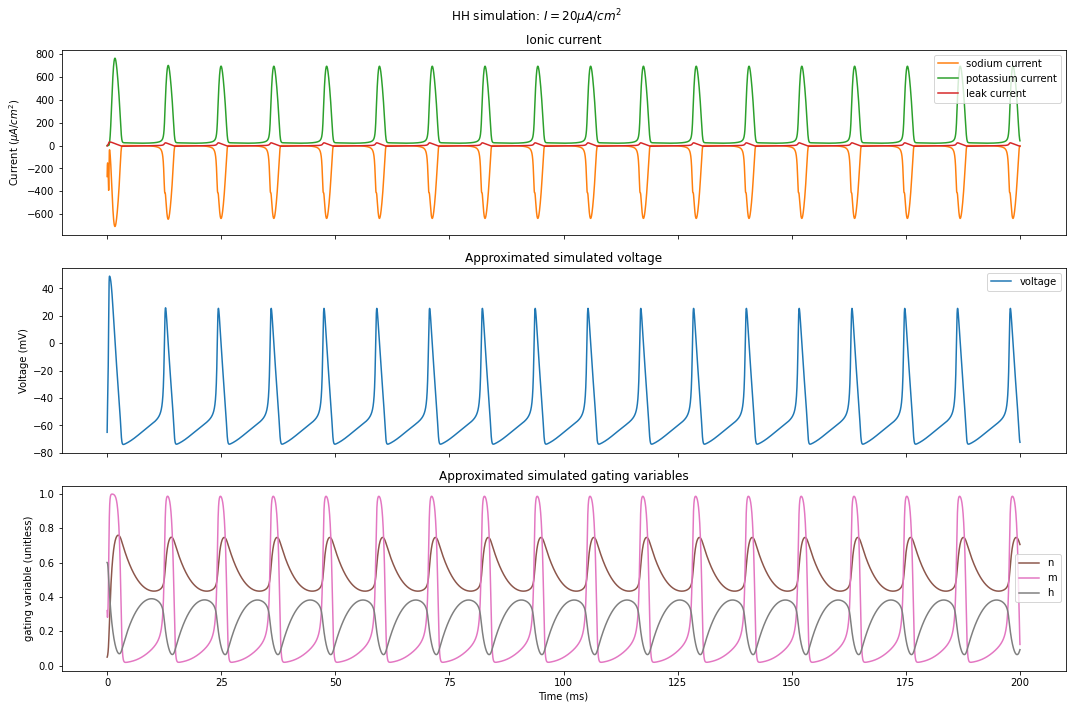

In [10]:
fig, axes = plt.subplots(3,1, figsize=(15, 10), sharex=True)

plt.suptitle(r'HH simulation: $I=20 \mu A / cm^2$')

#Current
sns.lineplot(ax=axes[0], x=time_steps, y=sodium_I, 
             color=colors[1], label='sodium current')
sns.lineplot(ax=axes[0], x=time_steps, y=potassium_I, 
             color=colors[2], label='potassium current')
sns.lineplot(ax=axes[0], x=time_steps, y=leak_I, 
             color=colors[3], label='leak current')

axes[0].set_title('Ionic current')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel(r'Current ($\mu A / cm^2$)')

#Potential
sns.lineplot(ax=axes[1], x=time_steps, y=approx_v, 
             color=colors[0], label='voltage')

axes[1].set_title('Approximated simulated voltage')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Voltage (mV)')

# Gating variables
sns.lineplot(ax=axes[2], x=time_steps, y=approx_n, 
             color=colors[5], label='n')
sns.lineplot(ax=axes[2], x=time_steps, y=approx_m, 
             color=colors[6], label='m')
sns.lineplot(ax=axes[2], x=time_steps, y=approx_h, 
             color=colors[7], label='h')

axes[2].set_title('Approximated simulated gating variables')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('gating variable (unitless)')

#fig.legend()
plt.tight_layout()
plt.show()

### Question 2.2 [3]

Why is the first action potential in the plot you made bigger than the remaining action potentials? Make sure you specificy which channel(s) would cause this & use the plots above as needed to support your answer.

><font color="firebrick">The larger amplitude of the first action potential is purely due to the gating variables' initial values. Specifically, the initial values for $n=0.32$ and $h=0.6$ are set to be polarized further from their resting values ($n>0.5$ and $h<0.5$). Both $n$ (the gating variable governing $Na$ channel activation) and $h$ (the gating variable governing $K$ inactivation) promote repolarization (and hyperpolarization). Therefore, setting them to polarized values inhibits their repolarization effect and enables a loop of further depolarization and increased $m$. See the figure below comparing the original initial values to modified ones, where $h=0.4$ and $n=0.5$. In the modified case, the first action potential is not bigger, but equal, to the rest of the spike train.

In [11]:
init_values_2_2 = [-65, .32, 0.5, 0.4]

approx_v_2_2, approx_n_2_2, approx_m_2_2, approx_h_2_2 =\
        euler_approx_HH(init_values_2_2, input_current, dt, t_inf)


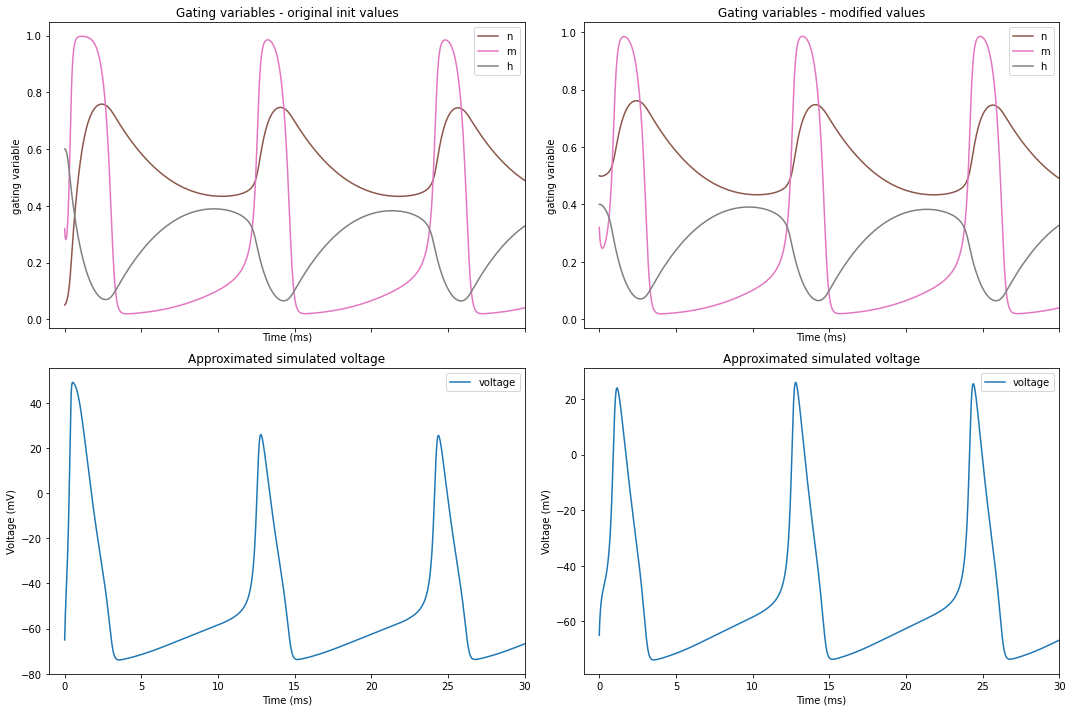

In [12]:
fig, axes = plt.subplots(2,2, figsize=(15, 10), sharex=True)

plt.title('Zoom in: comparing initial values')

axes[0][0].set_title('Gating variables - original init values')
axes[0][0].set_xlabel('Time (ms)')
axes[0][0].set_ylabel('gating variable')

sns.lineplot(ax=axes[0][0], x=time_steps, y=approx_n, 
             color=colors[5], label='n')
sns.lineplot(ax=axes[0][0], x=time_steps, y=approx_m, 
             color=colors[6], label='m')
sns.lineplot(ax=axes[0][0], x=time_steps, y=approx_h, 
             color=colors[7], label='h')

axes[1][0].set_title('Approximated simulated voltage')
axes[1][0].set_xlabel('Time (ms)')
axes[1][0].set_ylabel('Voltage (mV)')

sns.lineplot(ax=axes[1][0], x=time_steps, y=approx_v, 
             color=colors[0], label='voltage')


axes[0][1].set_title('Gating variables - modified values')
axes[0][1].set_xlabel('Time (ms)')
axes[0][1].set_ylabel('gating variable')

sns.lineplot(ax=axes[0][1], x=time_steps, y=approx_n_2_2, 
             color=colors[5], label='n')
sns.lineplot(ax=axes[0][1], x=time_steps, y=approx_m_2_2, 
             color=colors[6], label='m')
sns.lineplot(ax=axes[0][1], x=time_steps, y=approx_h_2_2, 
             color=colors[7], label='h')

axes[1][1].set_title('Approximated simulated voltage')
axes[1][1].set_xlabel('Time (ms)')
axes[1][1].set_ylabel('Voltage (mV)')

sns.lineplot(ax=axes[1][1], x=time_steps, y=approx_v_2_2,
             color=colors[0], label='voltage')

plt.xlim(-1,30)
plt.tight_layout()

### Question 2.3 [3]
Why does the membrane become hyperpolarized soon after an action potential? Be specific as to which channel(s) & mechanisms are causing this. 

><font color="firebrick">Post-action potential hyperpolarization, also known as undershoot, is mainly the result of the extended outflux of potassium. Repolarization begins with the inactivation of sodium, which stops the influx of (positively-charged) sodium into the cell and, in turn, its depolarization. As the cell further repolarizes, voltage-gated potassium channels open, allowing the outflux of positively charged potassium (down the voltage gradient). However, the potassium channels stay open past the membrane's resting potential (since $E_K = -77$), resulting in hyperpolarization of the cell. As the potassium channels close - the cell's potential increases back to its resting potential.



## Question 3: Current Step [10]
In this part, you will simulate an injected current pulse in order to validate your simulation. 


### Question 3.1 [2]
Copy your function form above, give it a name name (ie HH_sim_2), and edit it to include a current step stimulus. That is, your function should accept a current startpoint and endpoint such that $I(t) = 0$ if $t < start$ or $t > end$, and $I(t) = I$ if $start \leq t \leq end$.

### Question 3.2 [1]
Using the function you just wrote, use Euler's method to numerically integrate with a current step stimulus $I(t) = 0$ for $t < 50ms, t > 150ms$ and $I(t) = 10 \mu A / cm^2$ for $50ms \leq t \leq 150ms$. Set $\bar{g}_{Na}$ and $\bar{g}_{K} = 0$. In a two-part figure plot the injected current and the simulated voltage.

In [13]:
input_current_3_2 = np.zeros_like(time_steps)

#step current
input_current_3_2[5000:15000] = 10

#conductance change
g_K_3_2 = 0
g_Na_3_2 = 0

constants_3_2 = [C, g_Na_3_2, g_K_3_2, g_L, v_Na, v_K, v_L]

approx_v_3_2, approx_n_3_2, approx_m_3_2, approx_h_3_2 =\
            euler_approx_HH(init_values, input_current_3_2, dt, t_inf, constants_3_2)



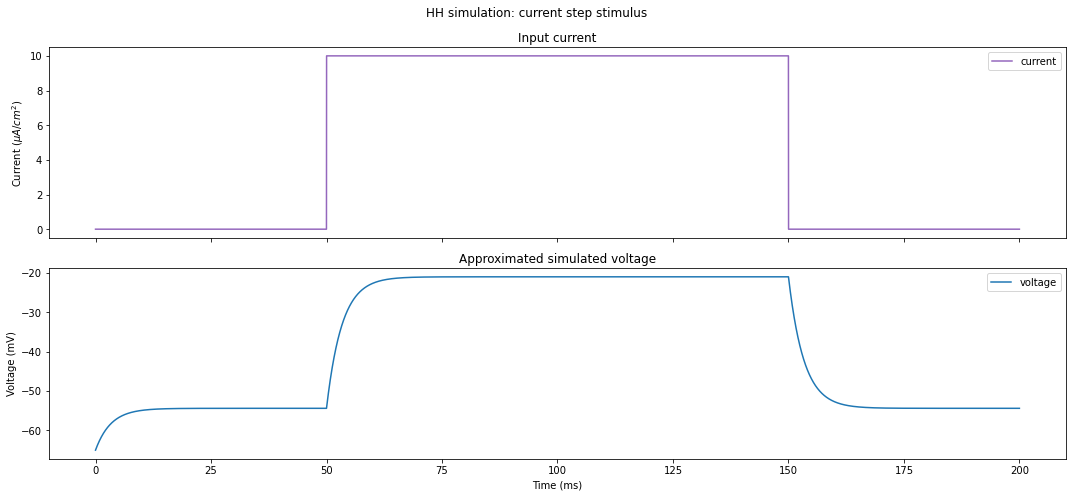

In [14]:
fig, axes = plt.subplots(2,1, figsize= (15,7), sharex=True)

plt.suptitle(r'HH simulation: current step stimulus')

#Current
axes[0].set_title('Input current')
sns.lineplot(ax=axes[0], x=time_steps, y=input_current_3_2, 
             color=colors[4], label='current')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Current ($\mu A / cm^2$)')

#Potential
axes[1].set_title('Approximated simulated voltage')
sns.lineplot(ax=axes[1], x=time_steps, y=approx_v_3_2,
             color=colors[0], label='voltage')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Voltage (mV)')

#fig.legend()
plt.tight_layout()
plt.show()

### Question 3.3 [4]
Explain the effect of setting of $\bar{g}_{Na}$ and $\bar{g}_{K}$ to zero. (1) Is the voltage transient you see due to active or passive electrical properties of the cell? Base your answer on your plot. (2) Identify the major electrical properties of the cell that influence the observed voltage trace. How would changing these properties influence the voltage dynamics? Don't overthink this: your answer should be ~2-3 sentences. 


><font color="firebrick"> Voltage change are a function of the input applied current, $dvdt=\frac{I}{C}$, where the current is the sum of the capacitive current and each ionic channel: $I=I_c+I_L+I_{Na}+I_k$. Setting the voltage-gated channels ($g_k$ and $g_{Na}$) conductance to 0, cancels the current flowing through these channels (as described by these equations: $I_k = \bar{g}_Kn^4(V - V_K)$ and $I_{Na} = \bar{g}_{Na}m^3h(V - V_{Na})$). Therefore, the only current flowing into the cell is the initial charging of the membrane capacitance and the leak channel. However, these do not allow enough current flow to depolarize the cell past the firing threshold, resulting in no action potentials. 
    
><font color="firebrick">(1) The obsereved voltage is due to the passive leak ion channels. The voltage equates when $dvdt=0$, meaning $\frac{I_c+I_L+I_{Na}+I_k}{C}=0$, solving this while $g_k=0$ and $g_{Na}=0$ shows that $V = \frac{I}{g_L} +V_L$, and here: $V=~-21.06$, which is the observed stable voltage. 

><font color="firebrick">(2) The main electrical property relevant to understanding (any) voltage trace is its conductance (and resistance $g=\frac{1}{R}$). Higher capacitance (or lower resistance) - will lower the observed voltage, given constant I. See Ohm's law $V=IR$. 

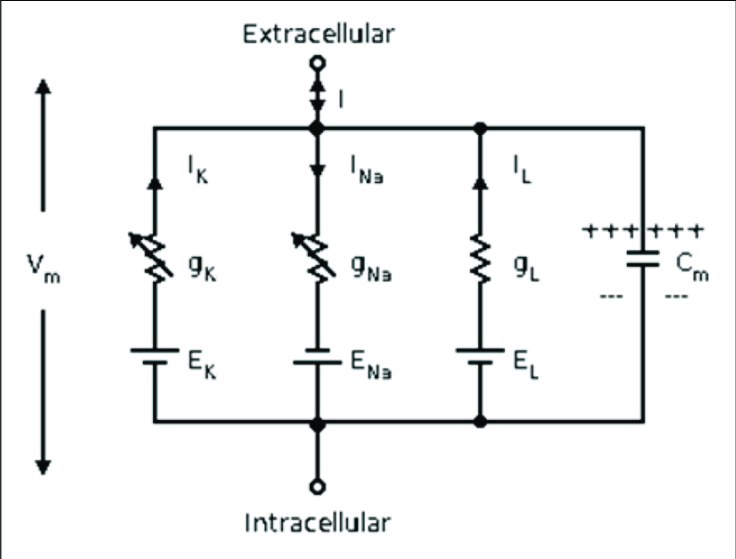

### Question 3.4 [3]
Recall the equivalent RC circuit corresponding to the Hodgkin Huxley model (see schematic above). Based on your answer to 3.3, with $\bar{g}_{Na}$ and $\bar{g}_{K} = 0$, describe the flow of current through this circuit for three time periods: 0 ms < t < 50 ms, 50 ms < t < 150 ms, and 150 ms < t < 200 ms. Be sure to (1) specify the direction and magnitude* of current flow in each branch of the circuit for these time periods and (2) link your answers with the voltage plot you generated in 3.3. You may assume that the injected current was generated by transiently attaching a battery with voltage $E_{battery}$ > $E_l$. 

*By magnitude we don't mean that you need to provide any numbers: a qualitive account of current is sufficient. 



><font color="firebrick"> **0 ms < t < 50 ms**: With $I=0$ and $V=-65$, no external input current. Some charged ions will flow (accrdoing to the electric gradient) into/out of the cell through the unselective leak channel. The cell will reach a balanced state at the leakage equilibrium potential $v_L = -55$. Which we can ascribe the voltage seen at this stage to the leakage resistance. See the voltage approaching $v_L$ in the figure above.
    
><font color="firebrick"> **50 ms < t < 150 ms**: $I=10$ and $V=-55$. The positive current flows into the cell, first charging the capacitor and circulates CW through the leakage resistors. The membrane capacitor properties governs the shape of the voltage increase, i.e., the upward curve. The cell depolarizes until it reaches $V~=-21$, the upper limit defined by the leak channel properties and the membrane capacitance (invariant with voltage).
    
><font color="firebrick"> **150 ms < t < 200 ms**: $I=0$ and $V~=-21$. With no more external current flowing inwards, the cell's capacitance slowly discharges (according to the electrical gradient), restoring the cell's resting potential. The shape of the voltage decrease curve is (like the increase above) dictated by the capacitance time scale.


## Question 4: HH Conceptual [5]



### Question 4.1 [2.5]
What is the main distinction between Hodgkin-Huxley type models and integrate-and-fire type models? What are the advantages of each type?

><font color="firebrick"> The main difference between the models is their level of abstraction. Hodgkin-Huxley models better describe the dynamical features of real neurons: allowing studying the properties of the spikes shape and the effect of different manipulations on it. Yet, they have *many* variables and are highly non-linear, making them computationally heavy and harder to mathematically analyze. Integrate-and-fire models are simpler. E.g., they're less biologically detailed. However, their higher level of abstraction allows the simulation of very large networks.
    

### Question 4.2 [2.5]

The first non-H-H conductance found was an inactivating K current. How would you add this  channel type to the model? What do you think would happen to the voltage response to an injected step of current? (Hint: read [the section on the Conor-stevens model from Theoretical Neuroscience by Dayan and Abbott](]https://drive.google.com/file/d/1aY7IJZtuxwr3nbd_VWUuFw2G4z3odCOx/view?usp=sharing)) Please answer in 3 sentences or less describing how each component relates to the model; code it up if you have the energy.

><font color="firebrick"> A current ($I_A$) is a potassium inactivating channel. Adding this channel will come in parallel to the other two ionic channels and the leakage channel, as described by Connor-Stevens, $I = I_C + I_{Na} + I_k + I_L + I_A$. I_A is defined with its gating variables, conductance, and equilibrium voltage. $I_A$'s primary effect is enhancing the refractory period. Since it is relatively fast to rise and decay, it has little to no effect on spike frequency adaptation. See a modification of the original HH simulation below. Notice, the Connor-Stevens parameterization introduces a temperature factor shift, i.e., it is not directly comparable to the original HH when introducing the same current.
    
><font color="firebrick"> The first figure below introduces the Connor-Stevens simulation for $I=20 \mu A / cm^2$, including the ionic current and the gating variables, as well as the output voltage. The second figure compares the FI curves for both models. HH generates a type II curve, whereas the Connor-Stevens model yields a type I curve of linear relations between firing rate to current.

In [15]:
### I_A current model

## parameterazation from http://www.math.pitt.edu/~bard/bardware/classes/compneuro/model/cs.ode

a_A = lambda V: (.0761*np.exp((V+94.22)/31.84)/(1+np.exp((V+1.17)/28.93)))**(1/3)
b_A = lambda V: 1/(1+np.exp((V+53.3)/14.54))**4
tau_a_A = lambda V: .3632+1.158/(1+np.exp((V+55.96)/20.12))
tau_b_A = lambda V: 1.24+2.678/(1+np.exp((V+50)/16.027))

da_dt = lambda V,a: (a_A(V)-a)/tau_a_A(V)
db_dt = lambda V,b: (b_A(V)-b)/tau_b_A(V)

v_A = -75
g_A = 47.7

A_current = lambda V, a, b, g_A, v_A, C: g_A*(a**3)*b*(V-v_A) /C



In [16]:
### modify HH functions
def CS_dV_dt(I, V, n, m, h, a, b, C, g_Na, g_K, g_L, g_A, v_Na, v_K, v_L, v_A):
    """
    
    Implenets the Connor-Stevens main equation computing the voltage of a 
     space-clamped membrane as a function of time $t$ for 
     
    Input:
        I (float) input current
        V (float) the transmembrane potential
        n/m/h/a/b (float) the relevant dimensionless gating parameter per channel
        C (float) capacitor
        g_Na (float) sodium conductance
        g_K (float) potassium conductance
        g_L (float) leak conductance
        g_A (float) A current conductance
        v_Na (float) sodium battery voltage
        v_K (float) potassium battery voltage
        v_L (float) leak battery voltage
        v_A (float) A current battery voltage

    
    Output:
        the voltage of a space-clamped membrane as a function of time $t$
    
    """
    return overall_cuurent(I, C) - sodium_current(V, m, h, g_Na, v_Na, C)- \
           potassium_current(V, n, g_K, v_K, C)- leak_current(V, g_L, v_L, C)-\
            A_current(V, a, b, g_A, v_A, C)

    
    
def euler_approx_CS(init_values, I, time_step, time_span, constants):
    '''
     Input:
        init_values (list of [V,m,n,h]) values for initial potential (V), gating parameters (n, m, h)
        I (1d array) input currents along time
        time_step (float) the time step size
        time_span (float) max time value (stopping condition)
    
    Output:
        
        V (1d array) potential value at each time step
        m, n, h, a, b (1d array) gating parameters value at each time step
    '''
    # number of timesteps
    n_timesteps = int(time_span/time_step)
    
    # preallocate space to save simulated values
    V = np.zeros(n_timesteps)
    m = np.zeros(n_timesteps)
    n = np.zeros(n_timesteps)
    h = np.zeros(n_timesteps)
    a = np.zeros(n_timesteps)
    b = np.zeros(n_timesteps)

    # assign initial values
    V[0] = init_values[0]
    m[0] = init_values[1]
    n[0] = init_values[2]
    h[0] = init_values[3]
    a[0] = init_values[4]
    b[0] = init_values[5]


    ## iteratively approximate the numerical value of each of HH's ODEs
    for time_i in range(1, n_timesteps):

        dVdt = CS_dV_dt(I[time_i-1], 
                                  V[time_i-1],
                                  n[time_i-1], 
                                  m[time_i-1], 
                                  h[time_i-1], 
                                  a[time_i-1], 
                                  b[time_i-1], *constants)
        
        dndt = dn_dt(V[time_i-1], n[time_i-1])
        dmdt = dm_dt(V[time_i-1], m[time_i-1])
        dhdt = dh_dt(V[time_i-1], h[time_i-1])
        dadt = da_dt(V[time_i-1], a[time_i-1])
        dbdt = db_dt(V[time_i-1], b[time_i-1])
        
        # update value: y(t+dt)=y(t)+ (dy/dt)*dt
        V[time_i] = V[time_i-1] + (dVdt * time_step)
        m[time_i] = m[time_i-1] + (dmdt * time_step)
        h[time_i] = h[time_i-1] + (dhdt * time_step)
        n[time_i] = n[time_i-1] + (dndt * time_step)
        a[time_i] = a[time_i-1] + (dadt * time_step)
        b[time_i] = b[time_i-1] + (dbdt * time_step)

        
    return V, n, m, h, a, b
    
  

In [17]:
#constants = [C, g_Na, g_K, g_L, g_A, v_Na, v_K, v_L, v_A]
constants_I_a = [C, 120, 20, 0.3, 47.7, 55, -72 , -17, -75]


In [18]:
approx_v_I_A, approx_n_I_A, approx_m_I_A, approx_h_I_A, approx_a_I_A, approx_b_I_A =\
            euler_approx_CS([-65, .32, 0.05, .6, 0.509, 0.426], 
                            input_current, dt, 
                            t_inf, constants_I_a)

In [19]:
# get ionic currents
sodium_I_A_I = sodium_current(approx_v_I_A, approx_m_I_A, approx_h_I_A, 120, 55, C)
potassium_I_A_I = potassium_current(approx_v_I_A, approx_n_I_A, 20, -72, C)
A_I = A_current(approx_v_I_A, approx_a_I_A, approx_b_I_A, 47.7, -75, C)
leak_I_A_I = leak_current(approx_v_I_A, 0.3, -17, C)


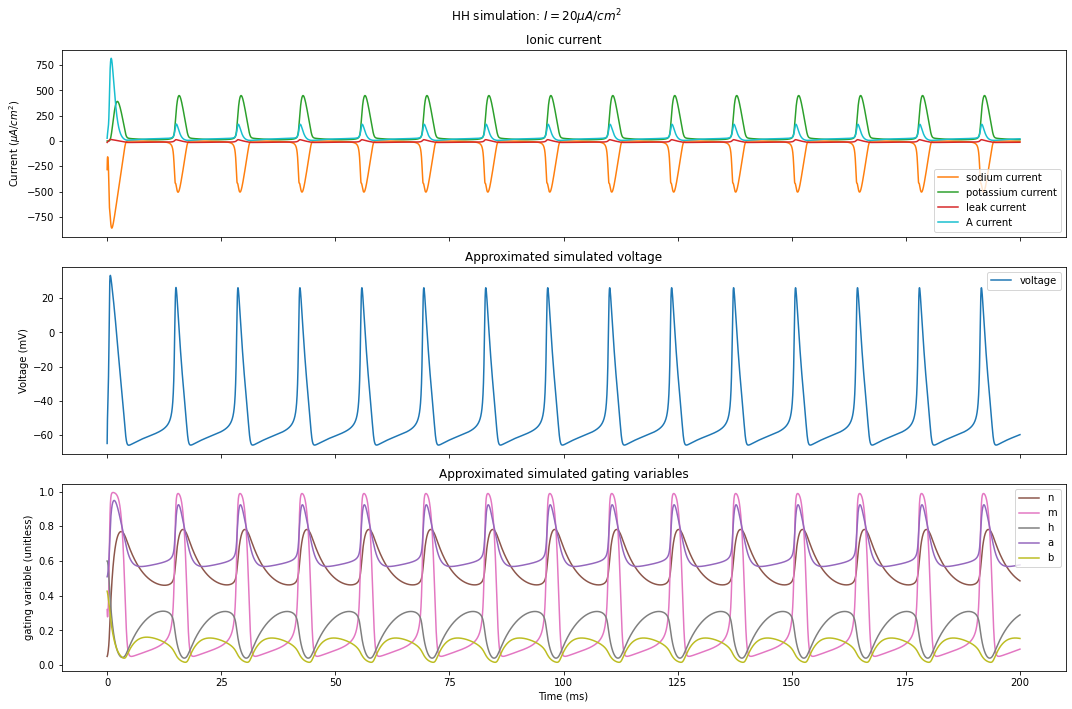

In [20]:
fig, axes = plt.subplots(3,1, figsize=(15, 10), sharex=True)

plt.suptitle(r'HH simulation: $I=20 \mu A / cm^2$')

#Current
sns.lineplot(ax=axes[0], x=time_steps, y=sodium_I_A_I, 
             color=colors[1], label='sodium current')
sns.lineplot(ax=axes[0], x=time_steps, y=potassium_I_A_I, 
             color=colors[2], label='potassium current')
sns.lineplot(ax=axes[0], x=time_steps, y=leak_I_A_I, 
             color=colors[3], label='leak current')
sns.lineplot(ax=axes[0], x=time_steps, y=A_I, 
             color=colors[9], label='A current')


axes[0].set_title('Ionic current')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel(r'Current ($\mu A / cm^2$)')

#Potential
sns.lineplot(ax=axes[1], x=time_steps, y=approx_v_I_A, 
             color=colors[0], label='voltage')

axes[1].set_title('Approximated simulated voltage')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Voltage (mV)')

# Gating variables
sns.lineplot(ax=axes[2], x=time_steps, y=approx_n_I_A, 
             color=colors[5], label='n')
sns.lineplot(ax=axes[2], x=time_steps, y=approx_m_I_A, 
             color=colors[6], label='m')
sns.lineplot(ax=axes[2], x=time_steps, y=approx_h_I_A, 
             color=colors[7], label='h')
sns.lineplot(ax=axes[2], x=time_steps, y=approx_a_I_A, 
             color=colors[4], label='a')
sns.lineplot(ax=axes[2], x=time_steps, y=approx_b_I_A, 
             color=colors[8], label='b')

axes[2].set_title('Approximated simulated gating variables')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('gating variable (unitless)')

#fig.legend()
plt.tight_layout()
plt.show()

In [21]:
F_I_HH = []
F_I_A = []

baseline_I = np.ones_like(time_steps)
I_range = np.linspace(15,50,20)

for i in I_range:
    approx_v_I_A, _, _, _, _, _ =\
            euler_approx_CS([-65, .32, 0.05, .6, 0.509, 0.426], 
                            baseline_I*i, dt, 
                            t_inf, constants_I_a)

    peaks_ids_I_A,_ = find_peaks(approx_v_I_A, 
                         height=0, 
                         distance=2)
    F_I_A.append(len(peaks_ids_I_A))
    
    approx_v_HH, _, _, _ =\
            euler_approx_HH([-65, .32, 0.05, .6], 
                            baseline_I*i-10, dt, 
                            t_inf, constants)
    
    peaks_ids_HH,_ = find_peaks(approx_v_HH, 
                         height=0, 
                         distance=2)
    
    F_I_HH.append(len(peaks_ids_HH))

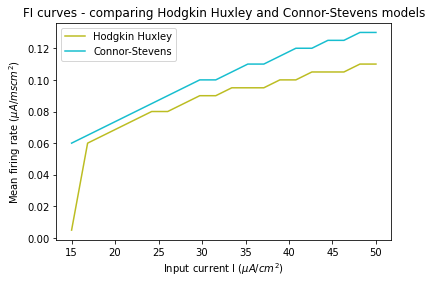

In [22]:
plt.title(r'FI curves - comparing Hodgkin Huxley and Connor-Stevens models')
plt.xlabel('Input current I ($\mu A / cm^2$)')
plt.ylabel('Mean firing rate ($\mu A /ms cm^2$)')

plt.plot(I_range,np.array(F_I_HH)/t_inf, 
         label = 'Hodgkin Huxley', color=colors[8])
plt.plot(I_range, np.array(F_I_A)/t_inf, 
         label = 'Connor-Stevens', color=colors[9])
plt.legend()
plt.show()